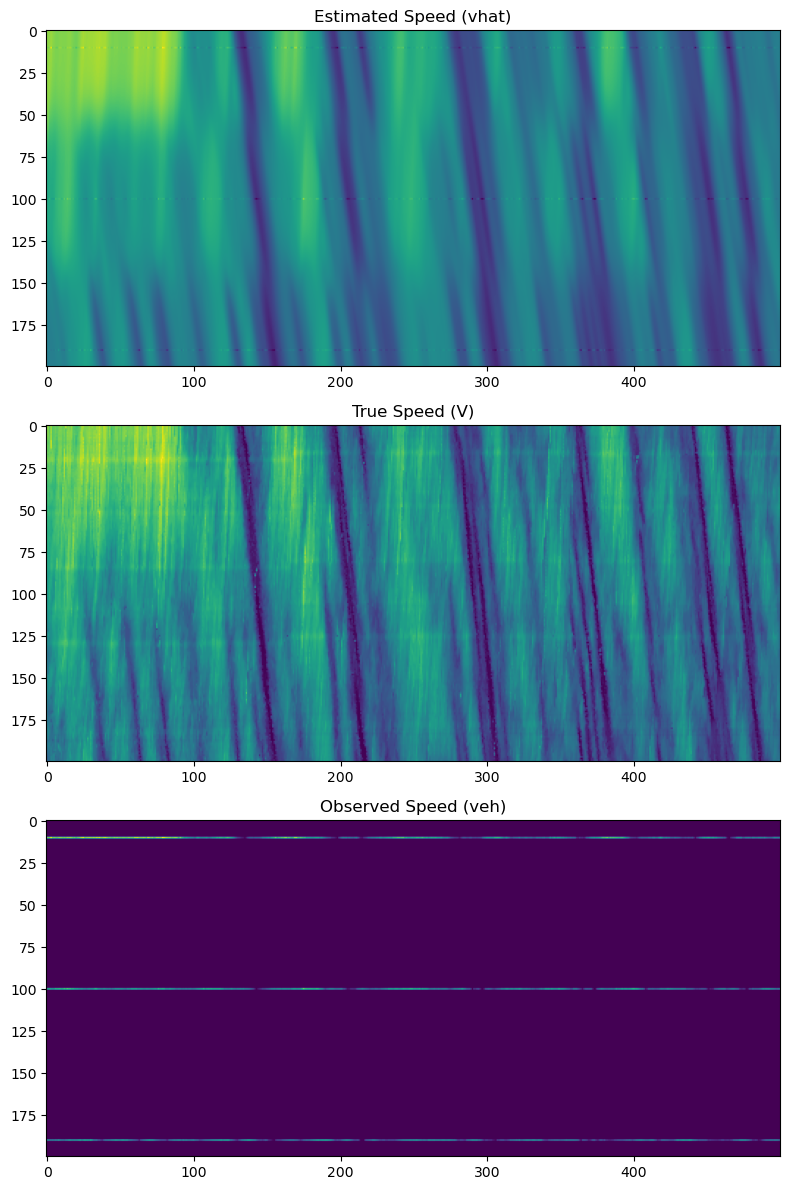

sigma=200, tau=10, rmse_test=6.1347
missing=0.98, rmse=6.1347, total_rmse=6.0886, mae=4.7476, total_mae=4.6765

Summary of parameter tests:
sigma | tau | missing_ratio | train_rmse | test_rmse | test_mae
200.0000 10.0000 0.9850 0.0000 6.1347 4.7476


In [ ]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# Load the speed grid data
data = sio.loadmat('../data/NGSIM/mat/speed_grid_full.mat')
V = data['full_speed']  # true speed field, shape (N, T)

# Construct observed locations (s) with NaNs everywhere except detectors
s = np.full_like(V, np.nan)
d_loc = [10, 100, 190]  # detector rows (0-based indexing assumed)
s[d_loc, :] = V[d_loc, :]

# Observed vehicle speeds (veh) and mask (q)
veh = np.zeros_like(s)
mask = ~np.isnan(s)
veh[mask] = s[mask]
q = veh > 0  # boolean mask of observed entries

# Dimensions
N, T = s.shape

# Training RMSE on observed points
Trainrmse = np.sqrt(np.linalg.norm((veh * q - V * q))**2 / np.sum(q))

# Spatial and temporal resolutions
deltax = 10  # feet between rows
deltat = 5   # seconds between frames

# Create spatial (idx) and temporal (idt) grids for broadcasting
idx = deltax * np.arange(1, N+1)[:, None]  # shape (N, 1)
idt = deltat * np.arange(1, T+1)[None, :]  # shape (1, T)

# Indices of training (observed) points
i_train, t_train = np.where(q)
vi = veh[i_train, t_train]
xi = idx[i_train, 0]
ti = idt[0, t_train]

# Prepare results storage
results = []

# Conversion unit (if needed)
unit = 1  # km/h to km/h (no change)

# Loop over parameters
for sigma in [200]:
    for tau in [10]:
        # Initialize accumulators
        sumPhi_free = np.zeros((N, T))
        sumPhi_cong = np.zeros((N, T))
        sumVf = np.zeros((N, T))
        sumVc = np.zeros((N, T))

        free_speed = -60 * unit
        cong_speed = 12

        # Accumulate kernel contributions
        for k in range(len(vi)):
            x_diff = np.abs(idx - xi[k]) / sigma
            t_diff_free = np.abs(idt - ti[k] - (idx - xi[k]) / free_speed) / tau
            t_diff_cong = np.abs(idt - ti[k] - (idx - xi[k]) / cong_speed) / tau

            phi_free = np.exp(-(x_diff + t_diff_free))
            phi_cong = np.exp(-(x_diff + t_diff_cong))

            sumPhi_free += phi_free
            sumPhi_cong += phi_cong
            sumVf += phi_free * vi[k]
            sumVc += phi_cong * vi[k]

        # Estimate free-flow and congested speeds
        Vfree = sumVf / sumPhi_free
        Vcong = sumVc / sumPhi_cong

        # Blend based on threshold
        deltav = 10 * unit
        vthr = 40
        w = 0.5 * (1 + np.tanh((vthr - np.minimum(Vfree, Vcong)) / deltav))

        # Final speed estimate
        vhat = w * Vcong + (1 - w) * Vfree
        # Insert exact observations where available
        vhat[q] = veh[q]

        # Compute test metrics on unobserved points
        diff = (V - vhat)[~q]
        n_test = diff.size
        rmse = np.sqrt(np.sum(diff**2) / n_test)
        mae = np.mean(np.abs(diff))

        # Total metrics
        total_rmse = np.sqrt(np.sum((V - vhat)**2) / (N * T))
        total_mae = np.mean(np.abs(V - vhat))

        # Missing data ratio
        mr = np.isnan(s).sum() / (N * T)
        results.append([sigma, tau, mr, Trainrmse, rmse, mae])

        # Plot the results
        fig, axes = plt.subplots(3, 1, figsize=(8, 12))
        axes[0].imshow(vhat, aspect='auto')
        axes[0].set_title('Estimated Speed (vhat)')
        axes[1].imshow(V, aspect='auto')
        axes[1].set_title('True Speed (V)')
        axes[2].imshow(veh, aspect='auto')
        axes[2].set_title('Observed Speed (veh)')
        plt.tight_layout()
        plt.show()

        print(f'sigma={sigma}, tau={tau}, rmse_test={rmse:.4f}')
        print(f'missing={mr:.2f}, rmse={rmse:.4f}, total_rmse={total_rmse:.4f}, mae={mae:.4f}, total_mae={total_mae:.4f}')

        # Save estimates and metrics
        sio.savemat('detector_NGSIM_ASM_hat_mat.mat', {
            'hat_mat': vhat,
            'rmse': rmse,
            'mae': mae,
            'total_rmse': total_rmse,
            'total_mae': total_mae
        })

# Optionally, convert results to NumPy array and print summary
results = np.array(results)
print('\nSummary of parameter tests:')
print('sigma | tau | missing_ratio | train_rmse | test_rmse | test_mae')
for row in results:
    print(' '.join(f'{val:.4f}' for val in row))
